In [1]:
library(plyr)
library(dplyr)
library(lattice)
library(reshape2)
library(Hmisc)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    combine, src, summarize

The following objects are masked from ‘package:plyr’:

    is.discrete, summarize

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



In [2]:
# Read CSV ----------------------------------------------------------------
airfareCSV <- read.csv("~/notebooks/AirFare/Data/tripRequest.csv", header=TRUE, dec=".", sep=";")

In [3]:
# [DataFrame] Drop double&uncess informtion --------------------------------------
airfare <- subset(airfareCSV, select = -c(requestString,tripRequest_id,requestDate,tripReturn,sliceDuration,tripStart,tripDestination))
airfare <- subset(airfare, select = -c(trip_id.1,trip_id.2,trip_id.3))
airfare <- subset(airfare, select = -c(tripOrder.1,tripOrder.2))
airfare <- subset(airfare, select = -c(tripRequest_id.1))

# Data Formats ------------------------------------------------------------
airfare$package <- as.POSIXct(strptime(airfare$package, "%d-%m-%Y"))
airfare$tripStartDeparture <- as.POSIXct(strptime(airfare$tripStartDeparture, "%Y-%m-%d %H:%M:%S"))
airfare$tripDestinationDeparture <- as.POSIXct(strptime(airfare$tripDestinationDeparture, "%Y-%m-%d %H:%M:%S"))
airfare$arrivalTime <- as.POSIXct(strptime(airfare$arrivalTime, "%Y-%m-%d %H:%M:%S"))
airfare$departureTime <- as.POSIXct(strptime(airfare$departureTime, "%Y-%m-%d %H:%M:%S"))

# Splitting Data into smaller Packages ------------------------------------
#data.fare <- airfare %>% group_by(trip_id) %>% summarise(saleTotal = mean(saleTotal, na.rm=TRUE))
subset.fares <- filter(airfare, marriedSegmentGroup==0) #Only one trip necessary for pricing
subset.fares <- subset.fares %>% select(trip_id,package,flightCarrier, tripStartDeparture,tripDestinationDeparture, operatingDisclosure,saleTotal)

# add daysBeforeDeparture/BookingDays
subset.fares$package <- as.POSIXct(subset.fares$package, format='%Y/%m/%d')
subset.fares$daysBeforeDeparture <- as.POSIXct(strftime(subset.fares$tripStartDeparture, format="%Y/%m/%d"))

# Difference of request date and actual departure (to see how many days before the flight it was "booked")
subset.fares$daysBeforeDeparture <- as.numeric(round(difftime(subset.fares$daysBeforeDeparture, subset.fares$package, units="days")))

# remove uncessary columns
subset.fares <- subset(subset.fares, select = -c(trip_id, package))

# remove operated by
#subset.fares$operatingDisclosure <- gsub("\\b(OPERATED|BY )\\b", "", subset.fares$operatingDisclosure, fixed=FALSE)
#subset.fares$operatingDisclosure <- gsub("[[:space:]]", "", subset.fares$operatingDisclosure, fixed=FALSE)
#subset.fares$operatingDisclosure <- sub("NULL", NA, subset.fares$operatingDisclosure, fixed=TRUE)

# combine columns and remove
#subset.fares$carrier <- gsub(", $", "", paste(subset.fares$flightCarrier, ifelse(is.na(subset.fares$operatingDisclosure), "*", subset.fares$operatingDisclosure) ,sep ="_"))
#subset.fares$carrier <- sub("\\_\\*", '', subset.fares$carrier)
#subset.fares <- subset(subset.fares, select = -c(flightCarrier, operatingDisclosure))

# output
head(subset.fares,3)

,flightCarrier,tripStartDeparture,tripDestinationDeparture,operatingDisclosure,saleTotal,daysBeforeDeparture
1,KL,2015-02-24 13:45:01,2015-03-03 19:31:05,OPERATED BY DELTA,477.99,0
2,AF,2015-02-24 13:45:01,2015-03-03 19:31:05,OPERATED BY DELTA,477.99,0
3,SQ,2015-02-24 08:20:01,2015-03-03 20:25:05,NULL,556.31,0


In [4]:
# sort data set for correct lead/lag
subset.fares.sorted <- subset.fares[with(subset.fares, order(flightCarrier, tripStartDeparture, tripDestinationDeparture, daysBeforeDeparture)), ]

# calculate lead/lag
subset.fares.lagged <- subset.fares.sorted %>% 
    group_by(flightCarrier, operatingDisclosure, tripStartDeparture, tripDestinationDeparture) %>% 
    mutate(
        #before.score = lag(saleTotal),
        #next.score = lead(saleTotal),
        priceDiff = (lead(saleTotal)-lag(saleTotal))
    )

In [5]:
head(subset.fares.lagged,3)

,flightCarrier,tripStartDeparture,tripDestinationDeparture,operatingDisclosure,saleTotal,daysBeforeDeparture,priceDiff
1,AF,2015-02-22 13:45:01,2015-03-01 19:31:05,OPERATED BY DELTA,566.99,0,NA
2,AF,2015-02-23 13:45:01,2015-03-02 19:31:05,OPERATED BY DELTA,711.99,0,NA
3,AF,2015-02-23 13:45:01,2015-03-02 19:31:05,OPERATED BY DELTA,612.99,1,NA


In [6]:
tapply(subset.fares.lagged$priceDiff, subset.fares.lagged$flightCarrier, summary)

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$AF
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-1242.00   -56.00     0.00   -24.43    20.73   885.60      131 

$KL
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-1242.00   -50.00     0.00   -23.48    19.04   885.60      183 

$LH
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-1010.00   -50.00     0.00   -22.16     0.12  1020.00     1524 

$SQ
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-330.600   -3.070    0.000   -2.767    0.000  212.500      119 

$UA
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-1650.00   -52.00     0.00   -22.43     0.00  1241.00     1521 


In [7]:
fares.lagged.summarise <- ddply(subset.fares.lagged, c('flightCarrier', 'operatingDisclosure', 'daysBeforeDeparture'), summarise,
                 ymean  = mean(priceDiff, na.rm=TRUE),
                 ymin   = quantile(priceDiff, 0,05, na.rm=TRUE),
                 ylow   = quantile(priceDiff, 0.25, na.rm=TRUE),
                 ymid   = quantile(priceDiff, 0.50, na.rm=TRUE), 
                 yquart = quantile(priceDiff, 0.75, na.rm=TRUE), 
                 ymax   = quantile(priceDiff, 0.975, na.rm=TRUE)             
)
head(fares.lagged.summarise,5)
str(fares.lagged.summarise)

,flightCarrier,operatingDisclosure,daysBeforeDeparture,ymean,ymin,ylow,ymid,yquart,ymax
1,AF,OPERATED BY DELTA,0,NaN,NA,NA,NA,NA,NA
2,AF,OPERATED BY DELTA,1,-50.16816,-786.56,-118.6225,-0.565,0.015,491.9207
3,AF,OPERATED BY DELTA,2,-63.69725,-1242,-118.2075,-0.45,0.3575,340.3632
4,AF,OPERATED BY DELTA,3,-51.63357,-742,-4.67,0,0.5825,432.6353
5,AF,OPERATED BY DELTA,4,-47.11762,-835,-0.825,0,28.5475,201.6903


'data.frame':	434 obs. of  9 variables:
 $ flightCarrier      : Factor w/ 5 levels "AF","KL","LH",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ operatingDisclosure: Factor w/ 4 levels "NULL","OPERATED BY DELTA",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ daysBeforeDeparture: num  0 1 2 3 4 5 6 7 8 9 ...
 $ ymean              : num  NaN -50.2 -63.7 -51.6 -47.1 ...
 $ ymin               : num  NA -787 -1242 -742 -835 ...
 $ ylow               : num  NA -118.623 -118.208 -4.67 -0.825 ...
 $ ymid               : num  NA -0.565 -0.45 0 0 ...
 $ yquart             : num  NA 0.015 0.358 0.582 28.548 ...
 $ ymax               : num  NA 492 340 433 202 ...


Warning message:
: Removed 4 rows containing missing values (geom_path).

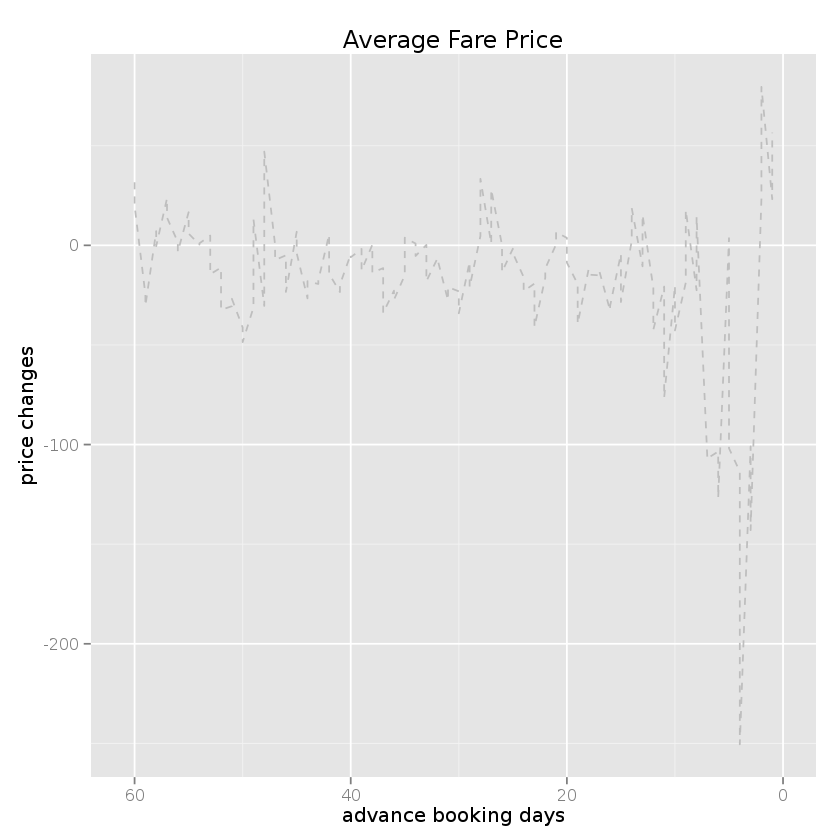

In [8]:
# Basic line plot with points
ggplot(data=filter(fares.lagged.summarise, flightCarrier=="LH"), aes(x=daysBeforeDeparture, group=1))+
geom_line(aes(y=ymean), linetype="dashed", colour="grey", stat="identity")+
#geom_line(aes(y=ylow), linetype=1, colour="grey25", stat="identity")+
#geom_line(aes(y=yquart), linetype=1, colour="grey50", stat="identity")+
scale_x_reverse()+
ggtitle('Average Fare Price')+
labs(x="advance booking days", y=expression(paste("price changes")))